In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import dalex as dx
from xgboost import XGBRegressor
import shap

We will work on the FIFA dataset.

In [2]:
df_in = pd.read_csv(Path.cwd() / "Fifa 23 Players Data.csv")
df_in.head(1)

,Known As,Full Name,Overall,Potential,Value(in Euro),Positions Played,Best Position,Nationality,Image Link,Age,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
0,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,...,91,88,91,67,66,67,62,53,62,22


In [3]:
Y_COLUMN = "Wage(in Euro)"
X_COLUMNS = [
    # "Overall",
    "Potential",
    "Age",
    "Height(in cm)",
    "Weight(in kg)",
    "Weak Foot Rating",
    "Pace Total",
    "Shooting Total",
    "Passing Total",
    "Dribbling Total",
    "Defending Total",
    "Physicality Total",
    "Crossing",
    "Finishing",
    "Heading Accuracy",
    "Short Passing",
    "Volleys",
    "Dribbling",
    "Curve",
    "Freekick Accuracy",
    "LongPassing",
    "BallControl",
    "Acceleration",
    "Sprint Speed",
    "Agility",
    "Reactions",
    "Balance",
    "Shot Power",
    "Jumping",
    "Stamina",
    "Strength",
    "Long Shots",
    "Aggression",
    "Interceptions",
    "Positioning",
    "Vision",
    "Penalties",
    "Composure",
    "Marking",
    "Standing Tackle",
    "Sliding Tackle",
]
df = df_in[X_COLUMNS + [Y_COLUMN]].copy().sample(n=len(df_in), random_state=42)
df[X_COLUMNS] = df[X_COLUMNS].astype(int)
df.head(1)

,Potential,Age,Height(in cm),Weight(in kg),Weak Foot Rating,Pace Total,Shooting Total,Passing Total,Dribbling Total,Defending Total,...,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Wage(in Euro)
10157,75,22,180,79,2,71,33,48,57,64,...,65,59,45,39,35,50,65,66,62,500


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[X_COLUMNS], df[Y_COLUMN], test_size=0.33, random_state=42)
X_train.shape, y_train.shape

((12421, 40), (12421,))

We will pick Random Forest as a base model.

In [5]:
rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)

1. Create permutation variable importance explainer for our dataset.

In [6]:
rf_explainer = dx.Explainer(rf_model, X_test, y_test)


Preparation of a new explainer is initiated

  -> data              : 6118 rows 40 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 6118 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fef9bf550d0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 4.98e+02, mean = 9e+03, max = 3.33e+05
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


  -> residuals         : min = -1.13e+05, mean = -3.65e+02, max = 1.53e+05
  -> model_info        : package sklearn

A new explainer has been created!


In [7]:
rf_explainer.model_performance()


,mse,rmse,r2,mae,mad
RandomForestRegressor,8.943004e+07,9456.745766,0.744392,4239.257927,1495.25


In [8]:
pvi = rf_explainer.model_parts(random_state=0, type='variable_importance')

In [9]:
fig = pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)
fig

Similar to the previous homeworks Reactions and Potential are of the highest importance. 

2. Let's train Linear Model and XGBoost with low and high capacity controlled by `max_depth` and `min_split_loss`.

In [10]:
linear_model = LinearRegression().fit(X_train, y_train)
xgboost_shallow = XGBRegressor(max_depth=4, min_split_loss=2).fit(X_train, y_train)
xgboost_deep = XGBRegressor(max_depth=9, min_split_loss=0).fit(X_train, y_train)

In [11]:
linear_explainer = dx.Explainer(linear_model, X_test, y_test)
xgb_shallow_explainer = dx.Explainer(xgboost_shallow, X_test, y_test, label='XGBRegressor Shallow')
xgb_deep_explainer = dx.Explainer(xgboost_deep, X_test, y_test, label='XGBRegressor Deep')


Preparation of a new explainer is initiated

  -> data              : 6118 rows 40 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 6118 values
  -> model_class       : sklearn.linear_model._base.LinearRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fef9bf550d0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -2.97e+04, mean = 8.92e+03, max = 5.86e+04
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -3.53e+04, mean = -2.84e+02, max = 2.06e+05
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 6118 rows 40 cols
  -> target variable 

/home/quczer/anaconda3/envs/xai/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [12]:
all_explainers = [rf_explainer, linear_explainer, xgb_shallow_explainer, xgb_deep_explainer]
for explainer in all_explainers:
    display(explainer.model_performance())

,mse,rmse,r2,mae,mad
RandomForestRegressor,8.943004e+07,9456.745766,0.744392,4239.257927,1495.25


,mse,rmse,r2,mae,mad
LinearRegression,2.147717e+08,14655.090633,0.386142,8286.892927,5894.466796


,mse,rmse,r2,mae,mad
XGBRegressor Shallow,9.717660e+07,9857.819433,0.722251,4307.217323,1452.89856


,mse,rmse,r2,mae,mad
XGBRegressor Deep,1.057865e+08,10285.254192,0.697642,4455.579885,1516.049805


In [13]:
for i, explainer in enumerate(all_explainers):
    pvi = explainer.model_parts(random_state=0, type="variable_importance")
    pvi.plot(show=False).update_layout(autosize=False, width=600, height=450).write_image(f'pvi_{i}.png')


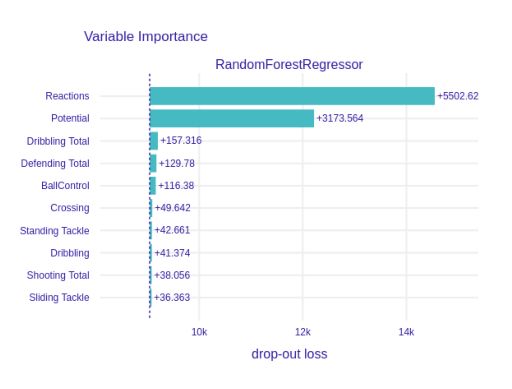

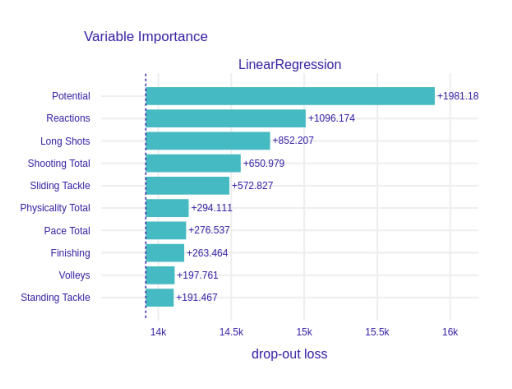

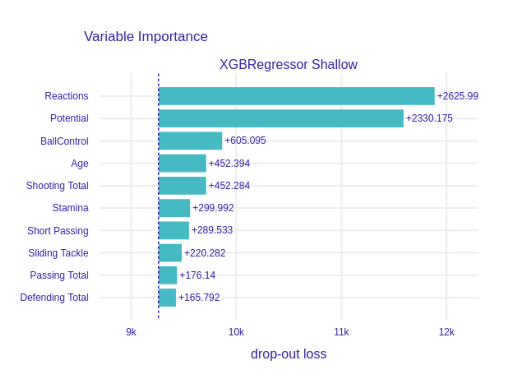

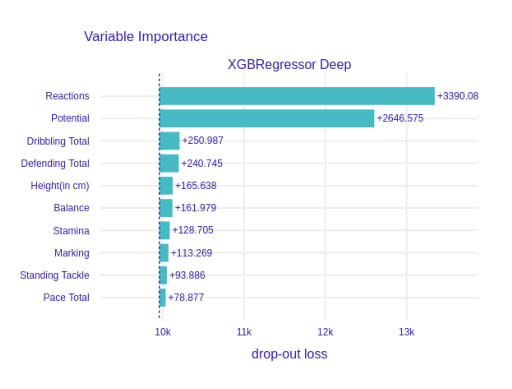

In [14]:
for i, explainer in enumerate(all_explainers):
    im = plt.imread(f'pvi_{i}.png')
    plt.axis('off')
    plt.imshow(im)
    plt.show()

Reactions and Potential stay at the top in all four models but in Random Forest and Deep XGB only they seem to be important for the prediction task.
Random Forest though has twice the loss of the deep XGB. Shallow XGB make use of more features. Linear Model has worse loss than any other model without the most important variable to start with, but seems to be robust to permutations of one variable.

I believe deep vs. shallow XGB differs that much because Reactions and Potential seem to be indeed crucial to predict and since deep one is deeper it has much higher chances of gettingone of these to variables to any base tree regressor.
Similar case might be with Random Forest Regressor - I believe in almost every tree one of two main features is present and that's why we see such a big jump in importances.

3a. Let's investigate how Permutation Variable Importance differ from impurity-based feature importances in forest classifiers.

In [15]:

def plot_importances(importances, title, ylabel):
    show_top = 10
    fig = plt.figure(figsize = (16, 6))
    top_columns = X_train.columns.values[np.argsort(-importances)][:show_top]
    plt.bar(top_columns, sorted(importances, reverse=True)[:show_top])
    plt.title(title)
    plt.ylabel(ylabel)

def plot_impurity_importances(tree_based_model, tag = ""):
    label = f'{type(tree_based_model).__name__} {tag}'
    importances = tree_based_model.feature_importances_
    title = f"Feature importances using MDI for {label}"
    ylabel = "Mean decrease in impurity"
    plot_importances(importances, title, ylabel)



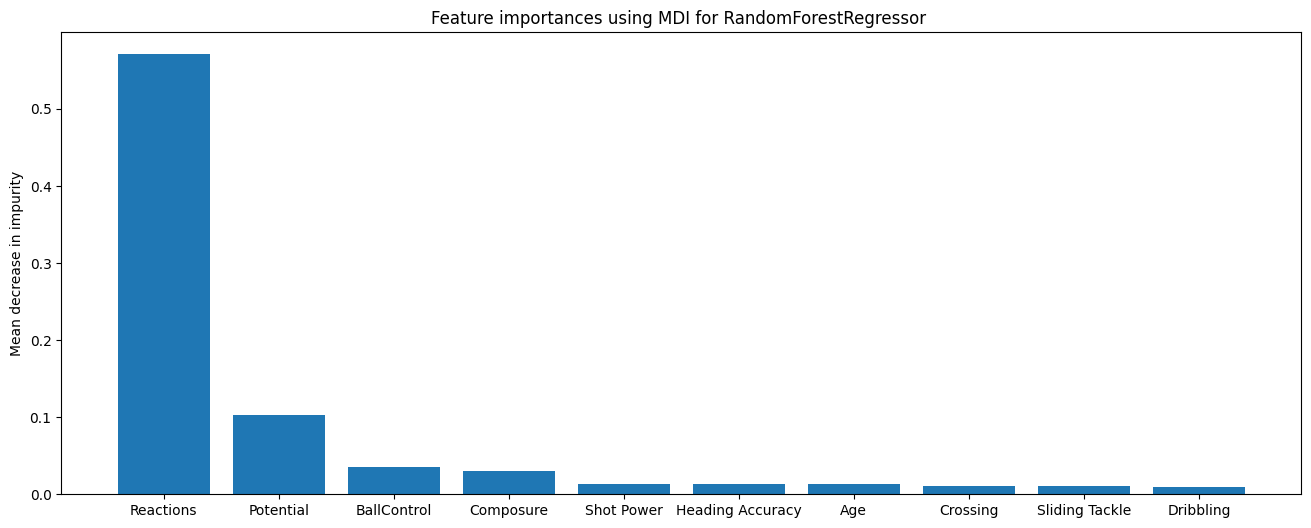

In [16]:
plot_impurity_importances(rf_model, )

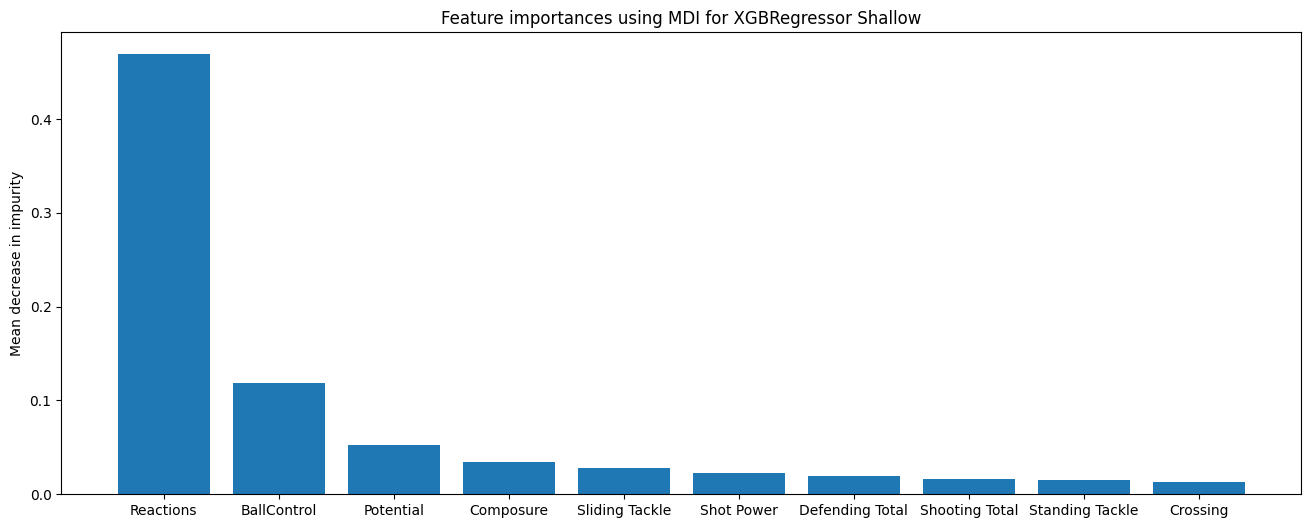

In [17]:
plot_impurity_importances(xgboost_shallow, "Shallow")

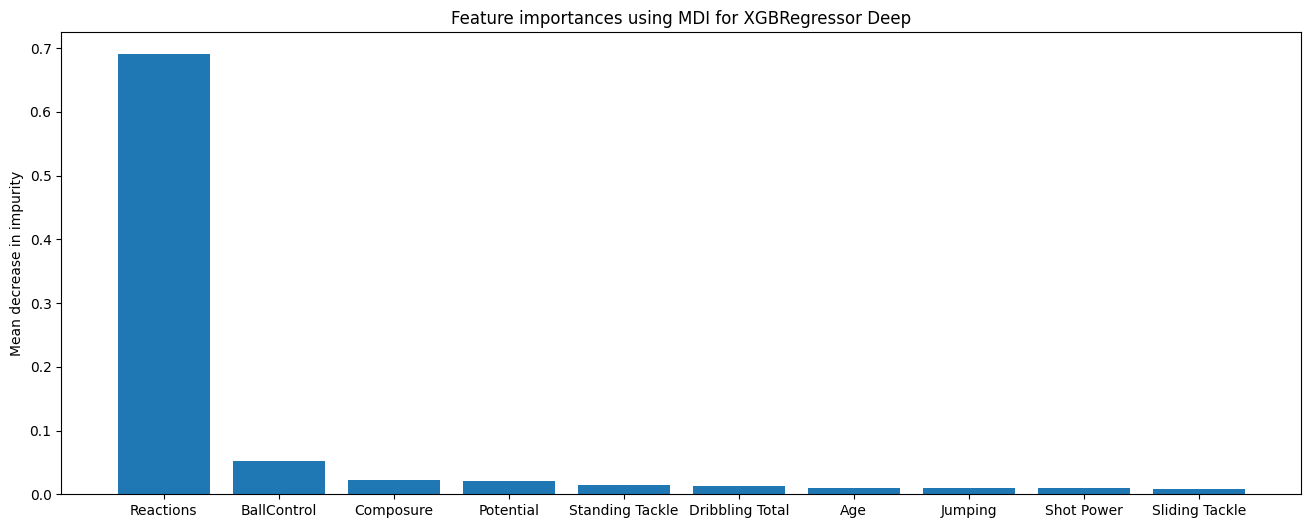

In [18]:
plot_impurity_importances(xgboost_deep, "Deep")


For Random forest Reactions remained at the top with much bigger difference to Potential, second place, which got closer to less important features.

In XGBoost regressors we see similar trend - in deeper model the differences between importances are larger. Interestingly enough Potential, which was second most important feature, very close to the top one, now in both cases is at the far. My guess of why that happens is that whenever Reactions is present as a feature it is the first split. I think gini favours splits higher in a tree even if the effect/accuracy that they bring on a prediction is similar. 

I think it is also important to note that these importances are computed without looking at the test set. Having that said any over-fitting present in a model may over-fit may appear here. So let's assume that splitting by BallControl which is not as highly correlated with Reactions as Potential may in principle (on the training set) introduce finer split. Then we will see that on the charts but in practice these splits may not add any value. 

So to sum it up I believe that Potential is highly correlated and slightly less important with Reactions but Reactions grab all the "glory". BallControl on the other hand does not help but is not as dependent on Reactions so it is second on the plot.

3b. Let's investigate tree-based feature importances again but using TreeSHAP algorithm instead.

In [19]:
def plot_tree_shap_importances(tree_based_model, tag = ""):
    n_samples = 200
    label = f'{type(tree_based_model).__name__} {tag}'
    title = f"SHAP importances for {label}"
    ylabel = f"Mean absolute SHAP value over {n_samples} samples"

    shap_explainer = shap.TreeExplainer(tree_based_model, X_test)
    shap_values = shap_explainer(X_test.sample(n=n_samples, random_state=42))
    importances = np.abs(shap_values.values).mean(axis=0)

    plot_importances(importances, title, ylabel)


100%|===================| 199/200 [00:22<00:00]        

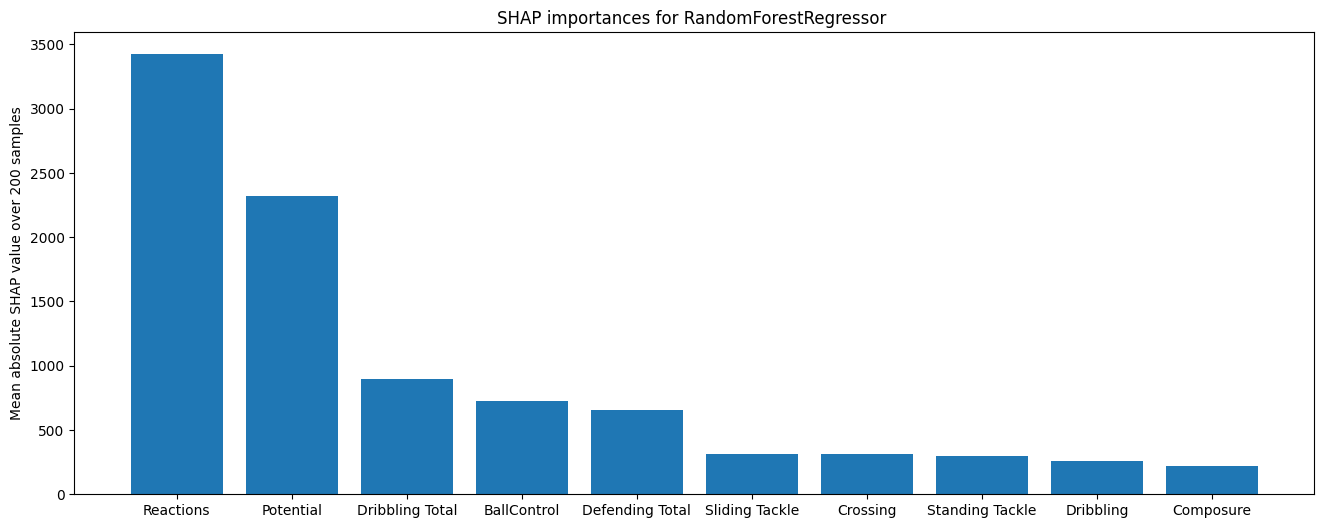

In [20]:
plot_tree_shap_importances(rf_model)

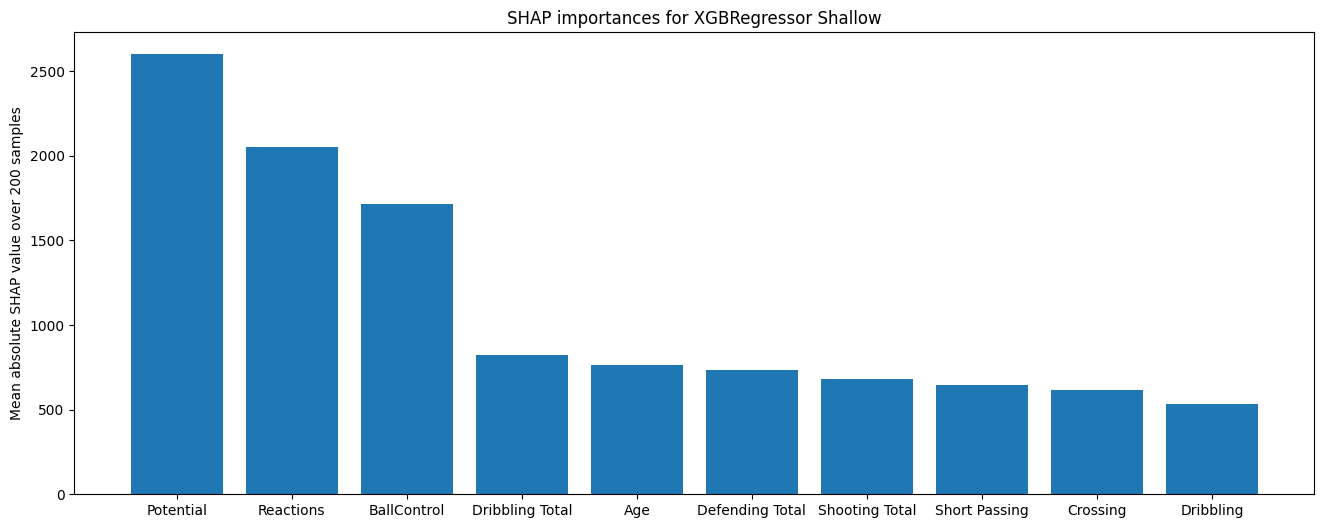

In [21]:
plot_tree_shap_importances(xgboost_shallow, "Shallow")


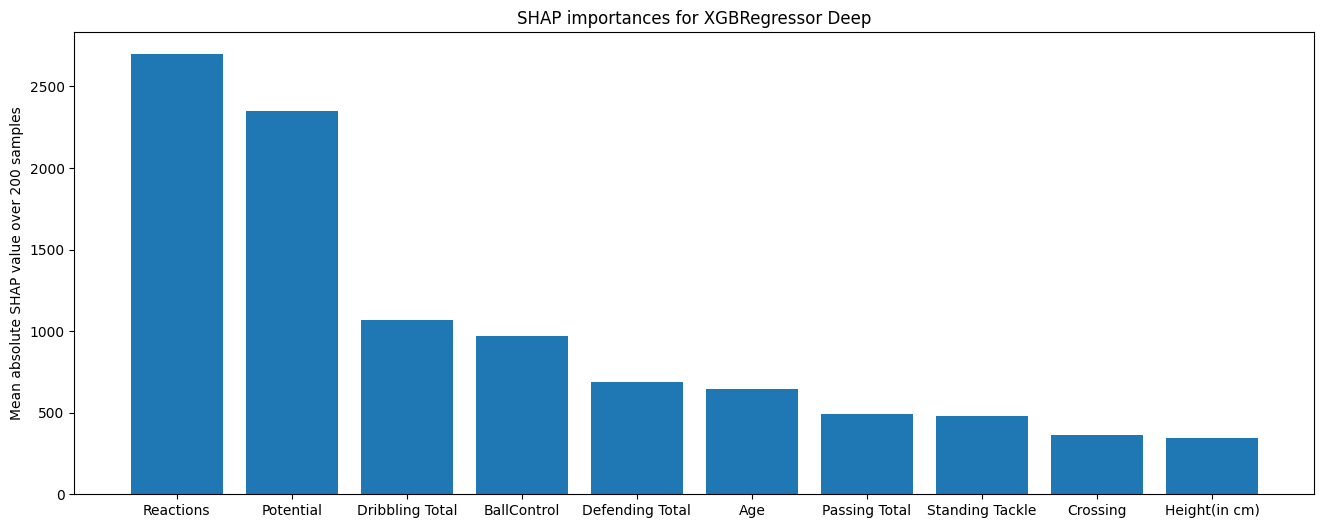

In [22]:
plot_tree_shap_importances(xgboost_deep, "Deep")



Here we see that the trend from permutation importance stayed the same but is milder - mainly Shallow XGBRegressor has less drastic differences between top 2/3 features and the rest than Deep XGBRegressor and Random Forest. Interestingly enough importances using SHAP swapped some features in comparison to PVI e.g. Potential in shallow xgb. 